Momentum Trading on Cryptocurrencies xizhi wang

Trading indictor 

Exponetinal Moving Average

    Short term vs Long term
Relative Strength Index

    RS =EMA(U,n)/ EMA(D,n)

    RSI =100- 100/(1+RS)

Trading Rules

    1.Buy at RSI <30 short term > long term

    2. Short at RSI >70 short term < long term

    3. else  don’t trade

The Triple Barrier Method

Three Rules:

The upper barrier is hit first. Label = “buy” or “1”.

The lower barrier  is hit first. Label = “sell” or “-1”.

The vertical barrier is hit first. max holding period reach


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

number of trading  22113
number of trading  22113
number of trading  1970


C:\Users\xizhi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


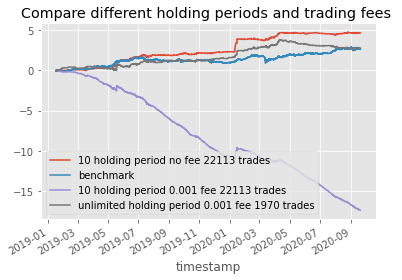

In [ ]:
# define a class for Backtesting 
class BackTest:
    '''
    function:
        open long: find our long position using open price
        open short: find our short position using open price
        reset_variablesL: reset all the variable to None 
        add_zeros: add 0 to store list for return, holding, and direction 
        close_position: calculate our close position and store the data
        check_barrier: check hit which barrier
        add_trade_cols: add data to the main dataframe
        run_backtest: run the backtest

    '''
    def __init__(self, csv_path, date_col, max_holding):
        # read the data 
        self.data = pd.read_csv(csv_path, parse_dates=[date_col],index_col=date_col,header=0)
        #calculate change in price
        self.data['t_plus'] = self.data.open.shift(-1)
        self.data['bench'] = (self.data.t_plus/self.data.open)-1
        
        # drop
        self.data.dropna(inplace=True)
        #copy the data
        self.df = self.data.copy()
        # set trade variables 
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None
        # vertical barrier variable
        self.max_holding = max_holding
        self.max_holding_limit = max_holding

     

        # special case of vertical barrier
        self.end_date = self.df.index.values[-1]

        self.store_return = []
        self.store_holding = []
        self.store_direction = []

    def open_long(self, price):
        '''

        :param price: price we open long at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        # direction 0 , 1 , -1 for hold long short
        self.direction = 1
        self.entry_price = price
        self.target_price = price * self.ub_bound
        self.stop_price = price * self.lb_bound
        self.add_zeros()

    def open_short(self, price):
        '''

        :param price: price we open short at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        self.direction = -1
        self.entry_price = price
        self.target_price = price * self.lb_bound
        self.stop_price = price * self.ub_bound
        self.add_zeros()

    def reset_variables(self):
        '''
        resets the variables after we close a trade
        '''
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None
        self.max_holding = self.max_holding_limit

    def add_zeros(self):
        self.store_return.append(0)
        self.store_holding.append(0)
        self.store_direction.append(0)


    def close_position(self, price):
        '''

        :param price: price we are exiting trade at
        :return: appends the trade pnl to the returns series
        and resets variables
        '''
        pnl = (price / self.entry_price - 1) * self.direction-self.fee
        
        self.store_return.append(pnl)
        self.store_direction.append(self.direction)
        holding = self.max_holding_limit - self.max_holding
        self.store_holding.append(holding)
        self.reset_variables()


    def check_barrier(self, price, time):
        # check upper horizontal barrier for long positions
        if price >= self.target_price and self.direction == 1:
            self.close_position(price)
        # check lower horizontal barrier for long positions
        elif price <= self.stop_price and self.direction == 1:
            self.close_position(price)
        # check lower horizontal barrier for short positions
        elif price <= self.target_price and self.direction == -1:
            self.close_position(price)
        # check upper horizontal barrier for short positions
        elif price >= self.stop_price and self.direction == -1:
            self.close_position(price)
        # cehck special case of vertical barrier
        elif time == self.end_date:
            self.close_position(price)
        # check vertical barrier
        elif self.max_holding <= 0:
            self.close_position(price)
        # if all above conditions not true, decrement max holding by 1 and append a zero to returns column
        else:
            self.max_holding = self.max_holding - 1
            self.add_zeros()

    def add_trade_cols(self):   
        '''
        merges the new columns we created for our backtest into our dataframe,
        also resets the returns series to empty lists, incase we want to change the strategy heartbeat.
        '''
        self.df['returns'] = self.store_return
        self.df['holding'] = self.store_holding
        self.df['direction'] = self.store_direction

        self.store_return = []
        self.store_holding = []
        self.store_direction = []

    def run_backtest(self):
        # find the signals based on trading strategy
        self.generate_signals()

        # loop over dataframe
        for row in self.df.itertuples():
            # if we get a long signal and do not have open position open a long
            if row.entry == 1 and self.open_pos is False:
                self.open_long(row.t_plus)
            # if we get a short position and do not have open position open a sort
            elif row.entry == -1 and self.open_pos is False:
                self.open_short(row.t_plus)
            # monitor open positions to see if any of the barriers have been touched, see function above
            elif self.open_pos:
                self.check_barrier(row.close, row.Index)
            else:
                self.add_zeros()    

        self.add_trade_cols()
        return self.df.returns.cumsum(), self.data.bench.cumsum()

    def plot_return(self):  
        plt.style.use('ggplot')
        self.df.returns.cumsum().plot()
    def plot_bench(self):
        self.data.bench.cumsum().plot()


class Momentum_Trading(BackTest):
    '''
    form our trading rules RSI and Expontial moving average
    Function:
        calculate_ma_rsi: calculate Exponetinal Moving Average and Relative Strength Index
        generate_signals: based on EMA and RSI determine if trade
        save_backtest: get the return 
    '''

    def __init__(self, csv_path, date_col, max_holding, ub_bound,
                 lb_bound, rsi_window, rsi_long, rsi_short,
                 ma_long, ma_short,fee):

        super().__init__(csv_path, date_col, max_holding)
        #
        self.ub_bound = ub_bound
        self.lb_bound = lb_bound

        #rsi parameters
        self.rsi_window = rsi_window
        self.rsi_long = rsi_long
        self.rsi_short = rsi_short

        #moving average parameters
        self.ma_long = ma_long
        self.ma_short = ma_short

        self.fee = fee


    def calculate_ma_rsi(self):
        '''

        https://en.wikipedia.org/wiki/Relative_strength_index
        param:
        change: change in close price
        ma_long: exponential moving average for long 
        ma_short: exponential moving average for short
        U: parameter in RSI calculate
        D: parameter in RSI calculate 
        RSI: relative strength index

        target: calculate moving average and relative strengh inedx
        '''
        df = self.df
        #calculate moving average 
        df['ma_long'] = df.close.ewm(span=self.ma_long, min_periods=self.ma_long-1).mean()
        df['ma_short'] = df.close.ewm(span=self.ma_short, min_periods=self.ma_short - 1).mean()

        #creat change column
        change = df.close.diff()
        #calculate RSI following formula 
        df['U'] = [x if x > 0 else 0 for x in change]
        df['D'] = [abs(x) if x < 0 else 0 for x in change]
        df['U'] = df.U.ewm(span=self.rsi_window,min_periods=self.rsi_window-1).mean()
        df['D'] = df.D.ewm(span=self.rsi_window,min_periods=self.rsi_window - 1).mean()
        df['RSI'] = 100 - 100/(1+(df.U / df.D))
        df.drop([ 'U', 'D'],axis=1, inplace=True)

    def generate_signals(self):
        df = self.df
        self.calculate_ma_rsi()
        df.dropna(inplace=True)
        # 1 if rsi < 30 & ma_short > ma_long, 0 otherwise
        df['longs'] = ((df.RSI < self.rsi_long) & (df.ma_short > df.ma_long))*1
        # -1 if rsi > 70 & ma_short < ma_long, 0 otherwise
        df['shorts'] = ((df.RSI > self.rsi_short) & (df.ma_short < df.ma_long))*-1
        df['entry'] = df.longs + df.shorts
        df.dropna(inplace=True)

    def save_backtest(self):
        '''
        return the return from backtest
        '''
        return self.df['returns']


if __name__ == '__main__':
    # set parameters for our trading stragies 
    csv_path = "ethereum.csv" #read file name 
    date_col = 'timestamp' #find the date column from csv
    max_holding = 10 #this is in time periods example 12 = 12 hours, if hourly, 6hours if 30min periods etc
    ub_bound = 1.05      # change this to change target (longs) stops (shorts)
    lb_bound = 0.995# change this to change stops (longs) targets (shorts)
    rsi_window = 14
    rsi_long = 30 
    rsi_short = 70
    ma_long = 200
    ma_short = 50
    fee = 0#set trading fee   

    M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short,fee)

    #M.data.change_resolution('60min')

    eth = M.run_backtest()
    M.plot_return()
    M.plot_bench()
    #print number of trades
    n_trade=abs(M.df.direction).sum()
    print('number of trading ',n_trade)
    #trading cost
    #cost =0.00023
    #eth_fee = pd.DataFrame([x-cost if x !=0  else 0 for x in eth ])
    #   plt.plot(eth_fee.cumsum())
    #uncomment if you wish to save the backtest
  
    #maker trade fee is 0.018%
        # total re
    max_holding = 10 #this is in time periods example 12 = 12 hours, if hourly, 6hours if 30min periods etc
    ub_bound = 1.05      # change this to change target (longs) stops (shorts)
    lb_bound = 0.995# change this to change stops (longs) targets (shorts)
    rsi_window = 14
    rsi_long = 30 
    rsi_short = 70
    ma_long = 200
    ma_short = 50
    fee = 0.001#set trading fee   

    M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short,fee)

    #M.data.change_resolution('60min')

    eth = M.run_backtest()
    M.plot_return()
    #print number of trades
    n_trade=abs(M.df.direction).sum()
    print('number of trading ',n_trade)

    max_holding = 10000000 #this is in time periods example 12 = 12 hours, if hourly, 6hours if 30min periods etc
    ub_bound = 1.05      # change this to change target (longs) stops (shorts)
    lb_bound = 0.995# change this to change stops (longs) targets (shorts)
    rsi_window = 14
    rsi_long = 30 
    rsi_short = 70
    ma_long = 200
    ma_short = 50
    fee = 0.001#set trading fee   

    M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short,fee)

    #M.data.change_resolution('60min')

    eth = M.run_backtest()
    M.plot_return()
    #print number of trades
    n_trade=abs(M.df.direction).sum()
    print('number of trading ',n_trade)
    plt.legend(['10 holding period no fee 22113 trades','benchmark','10 holding period 0.001 fee 22113 trades ','unlimited holding period 0.001 fee 1970 trades'])
    plt.title('Compare different holding periods and trading fees ')
    plt.show()




 Same code  in hourly data and 20 equally weight cryptos on google colab

In [ ]:
# define a class for Backtesting 
class BackTest:
    '''
    function:
        open long: find our long position using open price
        open short: find our short position using open price
        reset_variablesL: reset all the variable to None 
        add_zeros: add 0 to store list for return, holding, and direction 
        close_position: calculate our close position and store the data
        check_barrier: check hit which barrier
        add_trade_cols: add data to the main dataframe
        run_backtest: run the backtest

    '''
    def __init__(self, csv_path, date_col, max_holding):
        # read the data 
        self.data = pd.read_csv(csv_path, parse_dates=[date_col],index_col=date_col,header=0)
        #calculate change in price
        self.data['t_plus'] = self.data.open.shift(-1)
        self.data['t'] = self.data.close.shift(-1)
        self.data['bench'] = (self.data.t/self.data.close)-1
        # drop
        self.data.dropna(inplace=True)
        #copy the data
        self.df = self.data.copy()
        # set trade variables 
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None
        # vertical barrier variable
        self.max_holding = max_holding
        self.max_holding_limit = max_holding

     

        # special case of vertical barrier
        self.end_date = self.df.index.values[-1]

        self.store_return = []
        self.store_holding = []
        self.store_direction = []

    def open_long(self, price):
        '''

        :param price: price we open long at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        # direction 0 , 1 , -1 for hold long short
        self.direction = 1
        self.entry_price = price
        self.target_price = price * self.ub_bound
        self.stop_price = price * self.lb_bound
        self.add_zeros()

    def open_short(self, price):
        '''

        :param price: price we open short at
        :return: populates trade variables from constructor with relevant variables
        '''
        self.open_pos = True
        self.direction = -1
        self.entry_price = price
        self.target_price = price * self.lb_bound
        self.stop_price = price * self.ub_bound
        self.add_zeros()

    def reset_variables(self):
        '''
        resets the variables after we close a trade
        '''
        self.open_pos = False
        self.entry_price = None
        self.direction = None
        self.target_price = None
        self.stop_price = None
        self.max_holding = self.max_holding_limit

    def add_zeros(self):
        self.store_return.append(0)
        self.store_holding.append(0)
        self.store_direction.append(0)


    def close_position(self, price):
        '''

        :param price: price we are exiting trade at
        :return: appends the trade pnl to the returns series
        and resets variables
        '''
        pnl = (price / self.entry_price - 1) * self.direction-self.fee
        
        self.store_return.append(pnl)
        self.store_direction.append(self.direction)
        holding = self.max_holding_limit - self.max_holding
        self.store_holding.append(holding)
        self.reset_variables()


    def check_barrier(self, price, time):
        # check upper horizontal barrier for long positions
        if price >= self.target_price and self.direction == 1:
            self.close_position(price)
        # check lower horizontal barrier for long positions
        elif price <= self.stop_price and self.direction == 1:
            self.close_position(price)
        # check lower horizontal barrier for short positions
        elif price <= self.target_price and self.direction == -1:
            self.close_position(price)
        # check upper horizontal barrier for short positions
        elif price >= self.stop_price and self.direction == -1:
            self.close_position(price)
        # cehck special case of vertical barrier
        elif time == self.end_date:
            self.close_position(price)
        # check vertical barrier
        elif self.max_holding <= 0:
            self.close_position(price)
        # if all above conditions not true, decrement max holding by 1 and append a zero to returns column
        else:
            self.max_holding = self.max_holding - 1
            self.add_zeros()

    def add_trade_cols(self):
        '''
        merges the new columns we created for our backtest into our dataframe,
        also resets the returns series to empty lists, incase we want to change the strategy heartbeat.
        '''
        self.df['returns'] = self.store_return
        self.df['holding'] = self.store_holding
        self.df['direction'] = self.store_direction

        self.store_return = []
        self.store_holding = []
        self.store_direction = []

    def run_backtest(self):
        # find the signals based on trading strategy
        self.generate_signals()

        # loop over dataframe
        for row in self.df.itertuples():
            # if we get a long signal and do not have open position open a long
            if row.entry == 1 and self.open_pos is False:
                self.open_long(row.t_plus)
            # if we get a short position and do not have open position open a sort
            elif row.entry == -1 and self.open_pos is False:
                self.open_short(row.t_plus)
            # monitor open positions to see if any of the barriers have been touched, see function above
            elif self.open_pos:
                self.check_barrier(row.close, row.Index)
            else:
                self.add_zeros()    

        self.add_trade_cols()
        return self.df['returns'].cumsum(), self.df.bench.cumsum()

    def plot_return(self):  
        plt.style.use('ggplot')
        self.df.returns.cumsum().plot()
        plt.title(f"Strategy results for 1 hour timeframe")
        plt.show()


class Momentum_Trading(BackTest):
    '''
    form our trading rules RSI and Expontial moving average
    Function:
        calculate_ma_rsi: calculate Exponetinal Moving Average and Relative Strength Index
        generate_signals: based on EMA and RSI determine if trade
        save_backtest: get the return 
    '''

    def __init__(self, csv_path, date_col, max_holding, ub_bound,
                 lb_bound, rsi_window, rsi_long, rsi_short,
                 ma_long, ma_short,fee):

        super().__init__(csv_path, date_col, max_holding)
        #
        self.ub_bound = ub_bound
        self.lb_bound = lb_bound

        #rsi parameters
        self.rsi_window = rsi_window
        self.rsi_long = rsi_long
        self.rsi_short = rsi_short

        #moving average parameters
        self.ma_long = ma_long
        self.ma_short = ma_short

        self.fee = fee


    def calculate_ma_rsi(self):
        '''

        https://en.wikipedia.org/wiki/Relative_strength_index
        param:
        change: change in close price
        ma_long: exponential moving average for long 
        ma_short: exponential moving average for short
        U: parameter in RSI calculate
        D: parameter in RSI calculate 
        RSI: relative strength index

        target: calculate moving average and relative strengh inedx
        '''
        df = self.df
        #calculate moving average 
        df['ma_long'] = df.close.ewm(span=self.ma_long, min_periods=self.ma_long-1).mean()
        df['ma_short'] = df.close.ewm(span=self.ma_short, min_periods=self.ma_short - 1).mean()

        #creat change column
        change = df.close.diff()
        #calculate RSI following formula 
        df['U'] = [x if x > 0 else 0 for x in change]
        df['D'] = [abs(x) if x < 0 else 0 for x in change]
        df['U'] = df.U.ewm(span=self.rsi_window,min_periods=self.rsi_window-1).mean()
        df['D'] = df.D.ewm(span=self.rsi_window,min_periods=self.rsi_window - 1).mean()
        df['RSI'] = 100 - 100/(1+(df.U / df.D))
        df.drop([ 'U', 'D'],axis=1, inplace=True)

    def generate_signals(self):
        df = self.df
        self.calculate_ma_rsi()
        df.dropna(inplace=True)
        # 1 if rsi < 30 & ma_short > ma_long, 0 otherwise
        df['longs'] = ((df.RSI < self.rsi_long) & (df.ma_short > df.ma_long))*1
        # -1 if rsi > 70 & ma_short < ma_long, 0 otherwise
        df['shorts'] = ((df.RSI > self.rsi_short) & (df.ma_short < df.ma_long))*-1
        df['entry'] = df.longs + df.shorts
        df.dropna(inplace=True)

    def save_backtest(self):
        '''
        return the return from backtest
        '''
        return self.df['returns']
def find_return(csv_path):
  M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short,fee)
  re = M.run_backtest()
  return re

if __name__ == '__main__':
    # set parameters for our trading stragies 
    csv_path = f'/content/gdrive/MyDrive/MF796/new_data/Kucoin_BNBUSDT_1h.csv' #read file name 
    date_col = 'date' #find the date column from csv
    max_holding = 1000000 #this is in time periods example 12 = 12 hours, if hourly, 6hours if 30min periods etc
    ub_bound = 1.05      # change this to change target (longs) stops (shorts)
    lb_bound = 0.995# change this to change stops (longs) targets (shorts)
    rsi_window = 10
    rsi_long = 30 
    rsi_short = 70
    ma_long = 200
    ma_short = 50
    fee = 0.000 #set trading fee 

    M = Momentum_Trading(csv_path, date_col, max_holding, ub_bound, lb_bound, rsi_window,
                    rsi_long, rsi_short, ma_long, ma_short,fee)

    #M.data.change_resolution('60min')

    eth = M.run_backtest()
    M.plot_return()
    #print number of trades
    n_trade=abs(M.df.direction).sum()
    print(n_trade)
    #trading cost
    #cost =0.00023
    #eth_fee = pd.DataFrame([x-cost if x !=0  else 0 for x in eth ])
    #   plt.plot(eth_fee.cumsum())
    #uncomment if you wish to save the backtest
  
    #maker trade fee is 0.018%


    # total re
    x = find_return(csv_path)
    print(x[0])
    day =x[0].index
    print(len(day))
    #xizhi wang plot benchmark return and portfolio return 
    entries = os.listdir('/content/gdrive/MyDrive/MF796/crpyto_data')
    length = 21834 
    bench =np.zeros(length)
    portfolio = np.zeros(length)
    for entry in entries:
      
      re =find_return(f'/content/gdrive/MyDrive/MF796/new_data/{entry}')
      bench +=np.array(re[1])/20
      portfolio += np.array(re[0])/20
    day =pd.to_datetime(day)
    plt.figure()
    plt.rcParams["figure.figsize"] = (8,3)
    plt.plot(day,bench)
    plt.plot(day,portfolio)
    plt.legend(['benchmark','portfolio'])
    plt.title('Portfolio return vs Benchmark')
    plt.show()
  


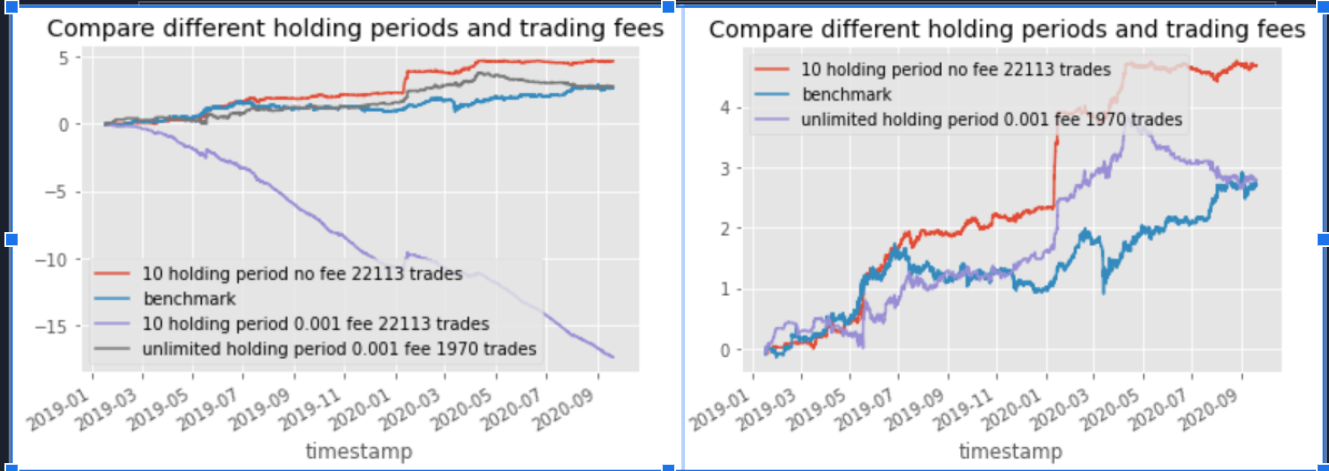